In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # graphical display
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
all_data = pd.read_csv('Data/Real_Estate_Data/data.csv')
all_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
# Sperate train and test set

train_df, test_df, y_train, y_test = train_test_split(all_data.drop(columns='CRIM'), all_data['CRIM'], test_size=0.21, random_state=0)
print(train_df.shape)



(403, 13)


In [4]:
#Normal Distirbution

lr = LinearRegression()

linMod = []

for col in train_df.columns.drop(['CHAS']):
    
    #Simple model
    X = train_df[col].fillna(value=train_df[col].median()).values
    lr.fit(X[:,np.newaxis],y_train)
    score_s=lr.score(X[:,np.newaxis], y_train)
    
    #only logarithm
    X_log = np.log1p(X)
    lr.fit(X_log[:,np.newaxis], y_train)
    score_l=lr.score(X_log[:,np.newaxis], y_train)
    
    linMod.append({
        'simple': score_s,
        'log': score_l,
    })
    
linMod = pd.DataFrame(linMod)
linMod['features'] = train_df.columns.drop(['CHAS'])
linMod.sort_values(by='simple', ascending=False, inplace=True)


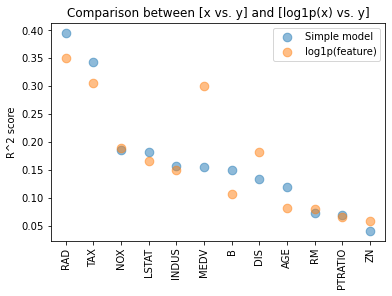

In [5]:
#R^2 Results

plt.scatter(np.arange(linMod.shape[0]), linMod['simple'], color='C0', alpha =0.5, s=75, label='Simple model')
plt.scatter(np.arange(linMod.shape[0]), linMod['log'], color='C1',alpha =0.5, s=75,label='log1p(feature)')
plt.xticks(np.arange(linMod.shape[0]), linMod['features'], rotation=90)
plt.ylabel('R^2 score')
plt.legend()
plt.title('Comparison between [x vs. y] and [log1p(x) vs. y]')
plt.show()

In [6]:


col_lg = linMod.loc[linMod['log']>linMod['simple'], 'features']

# Take the columns "as they are"
df_simple = train_df.drop(columns=['CHAS']).copy() 

for c in train_df.columns.drop(['CHAS']):
    df_simple[c].fillna(df_simple[c].median(), inplace=True)

# Take the log1p(x) only for the columns where the log1p(x) has a higher R^2 score
df_log = train_df.drop(columns=['CHAS']).copy() 

for c in train_df.columns.drop(['CHAS']):
    df_log[c].fillna(df_log[c].median(), inplace=True)
for c in col_lg:
    df_log[c] = np.log1p(df_log[c])
    
# Take the log1p(x) for all columns
df_alllog = train_df.drop(columns=['CHAS']).copy() 

for c in train_df.columns.drop(['CHAS']):
    df_alllog[c].fillna(df_alllog[c].median(), inplace=True)
    df_alllog[c] = np.log1p(df_alllog[c])
    

scaler = StandardScaler()
X_s = scaler.fit_transform(df_simple.values)
X_l = scaler.fit_transform(df_log.values)
X_al = scaler.fit_transform(df_alllog.values)

In [7]:
lr = LinearRegression()

#simple model
lr.fit(X_s, y_train)
print('MSE for simple model: {:.2f}'.format(MSE(y_train, lr.predict(X_s))))

#log model
lr.fit(X_l, y_train)
print('MSE for log model: {:.2f}'.format(MSE(y_train, lr.predict(X_l))))

#ALL log model
lr.fit(X_al, y_train)
print('MSE for ALL log model: {:.2f}'.format(MSE(y_train, lr.predict(X_al))))

MSE for simple model: 28.54
MSE for log model: 25.24
MSE for ALL log model: 26.67


In [8]:
#Model

In [9]:
def preprocess(df1, df2): # df1 is the dataframe to preprocess, based on df2 informations
    
    df1 = df1.copy() #work on a copy
    
    #set column names
    cont_col = df1.drop(columns=['CHAS']).columns
    col_lg = ['MEDV', 'NOX', 'DIS', 'RM', 'ZN']
    
    #compute log transform
    for c in cont_col:
        df1[c].fillna(df2[c].median(), inplace=True)
    for c in col_lg:
        df1[c] = np.log1p(df1[c])
        
    #Feature engineering
    df1['ZN_binary'] = [1 if x>0 else 0 for x in df1['ZN']]
    df1['RAD_binary'] = [1 if x>20 else 0 for x in df1['RAD']]
    df1['TAX_binary'] = [1 if x>600 else 0 for x in df1['TAX']]
    
    #Polynomial features
    for c in cont_col:
        for d in [0.5, 2, 3]:
            name = '{}**{}'.format(c, d)
            df1[name] = df1[c]**d
        #One-Hot Encoding
    df1 = pd.get_dummies(df1, dummy_na=False)
    
    return df1

In [10]:
train_df_preprocessed = preprocess(train_df, train_df)
test_df_preprocessed = preprocess(test_df, train_df)

#ensure same columns
test_df_preprocessed = test_df_preprocessed.reindex(columns=train_df_preprocessed.columns, fill_value=0) #Ensure same columns

In [11]:
scaler = StandardScaler()
train_df_preproc_scaled = scaler.fit_transform(train_df_preprocessed)
test_df_preproc_scaled = scaler.transform(test_df_preprocessed)

In [12]:
linreg = LinearRegression() #creates the object
linreg.fit(train_df_preproc_scaled, y_train) #fit the model using the train data rescaled
mae_model1 = MSE(y_test, linreg.predict(test_df_preproc_scaled))
print('MSE Linear Regression: {:.6f}'.format(mae_model1))

MSE Linear Regression: 85.582651
